In [11]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install required packages
!pip install -U sentence-transformers torch torchvision

# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# Load datasets
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/final codes/train_350.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/final codes/mal_full_offe_test_MODIFY (1).csv", header=None, names=["text", "label"])

# Prepare data for training and testing
train_sent_m = train['text'].tolist()
train_label_m = train['label'].tolist()
test_sent_m = test['text'].tolist()
test_label_m = test['label'].tolist()

# Encode labels
le = LabelEncoder()
train_labels_encoded = le.fit_transform(train_label_m)

# Handle unknown labels
unique_train_labels = set(le.classes_)
test_labels_corrected = [label if label in unique_train_labels else "unknown" for label in test_label_m]
if "unknown" not in le.classes_:
    le.classes_ = np.append(le.classes_, "unknown")

test_labels_encoded = le.transform(test_labels_corrected)
print("Classes in LabelEncoder:", le.classes_)

# Load BERT model for embeddings
trans_model = SentenceTransformer('bert-base-multilingual-cased')
trans_model.max_seq_length = 128

# Generate embeddings
train_sentence_embeddings = trans_model.encode(train_sent_m)
test_sentence_embeddings = trans_model.encode(test_sent_m)

# Convert to PyTorch tensors
train_X = torch.tensor(train_sentence_embeddings, dtype=torch.float32)
test_X = torch.tensor(test_sentence_embeddings, dtype=torch.float32)
train_Y = torch.tensor(train_labels_encoded, dtype=torch.long)
test_Y = torch.tensor(test_labels_encoded, dtype=torch.long)

# Compute class weights
all_classes = np.unique(train_labels_encoded)
class_weights = compute_class_weight('balanced', classes=all_classes, y=train_labels_encoded)
class_weights = torch.tensor(class_weights, dtype=torch.float32)
print("Computed class weights:", class_weights)

# Define Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        log_probs = F.log_softmax(inputs, dim=-1)
        targets_one_hot = F.one_hot(targets, num_classes=inputs.shape[-1]).float()
        ce_loss = -(targets_one_hot * log_probs).sum(dim=-1)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        if self.alpha is not None:
            focal_loss *= self.alpha[targets]
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

# Define MLP Classifier
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Model Setup
input_dim = train_X.shape[1]
num_classes = len(le.classes_)
model = MLPClassifier(input_dim, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_X, train_Y = train_X.to(device), train_Y.to(device)
test_X, test_Y = test_X.to(device), test_Y.to(device)
class_weights = class_weights.to(device)

criterion = FocalLoss(alpha=class_weights, gamma=2)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training
batch_size = 64
train_dataset = TensorDataset(train_X, train_Y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

num_epochs = 80
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_X, batch_Y in train_loader:
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    outputs = model(test_X)
    predictions = torch.argmax(outputs, dim=1)

predictions = predictions.cpu().numpy()
test_labels_np = test_Y.cpu().numpy()

# Filter out unseen label predictions
known_label_indices = [i for i, label in enumerate(test_labels_np) if label in all_classes]
test_labels_filtered = test_labels_np[known_label_indices]
predictions_filtered = predictions[known_label_indices]

# Evaluation Scores
print(classification_report(test_labels_filtered, predictions_filtered, target_names=le.inverse_transform(all_classes)))

print("Confusion Matrix:")
print(confusion_matrix(test_labels_filtered, predictions_filtered))

# Macro metrics
accuracy = accuracy_score(test_labels_filtered, predictions_filtered)
precision = precision_score(test_labels_filtered, predictions_filtered, average='macro', zero_division=0)
recall = recall_score(test_labels_filtered, predictions_filtered, average='macro', zero_division=0)
f1 = f1_score(test_labels_filtered, predictions_filtered, average='macro', zero_division=0)

print("\nMacro Metrics:")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

# Save the model
pkl_filename = "/content/drive/MyDrive/Colab Notebooks/MLP_model.pkl"
torch.save(model.state_dict(), pkl_filename)
print(f"Model saved to '{pkl_filename}'.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Classes in LabelEncoder: ['Not_offensive' 'Offensive_Untargetede' 'Offensive_target_insult_Group'
 'Offensive_target_insult_individual' 'not-malayalam' 'unknown']
Computed class weights: tensor([ 0.2300, 14.7355, 15.0083,  8.3337,  2.5189])
Epoch [1/80], Loss: 0.9458
Epoch [2/80], Loss: 0.6922
Epoch [3/80], Loss: 0.6231
Epoch [4/80], Loss: 0.5629
Epoch [5/80], Loss: 0.5172
Epoch [6/80], Loss: 0.4805
Epoch [7/80], Loss: 0.4418
Epoch [8/80], Loss: 0.4073
Epoch [9/80], Loss: 0.3840
Epoch [10/80], Loss: 0.3575
Epoch [11/80], Loss: 0.3375
Epoch [12/80], Loss: 0.3092
Epoch [13/80], Loss: 0.2986
Epoch [14/80], Loss: 0.2740
Epoch [15/80], Loss: 0.2493
Epoch [16/80], Loss: 0.2413
Epoch [17/80], Loss: 0.2172
Epoch [18/80], Loss: 0.2070
Epoch [19/80], Loss: 0.1906
Epoch [20/80], Loss: 0.1771
Epoch [21/80], Loss: 0.1643
Epoch [22/80], Loss: 0.1500
Epoch [23/80], Loss: 0.1428
Epoch [24/80], Loss: 0.1272
Epoch [25/80], Loss: 0.1194
Epoch [26/80], Loss: 0.1099
Epoch [27/80], Loss: 0.1010
Epoch [28/80

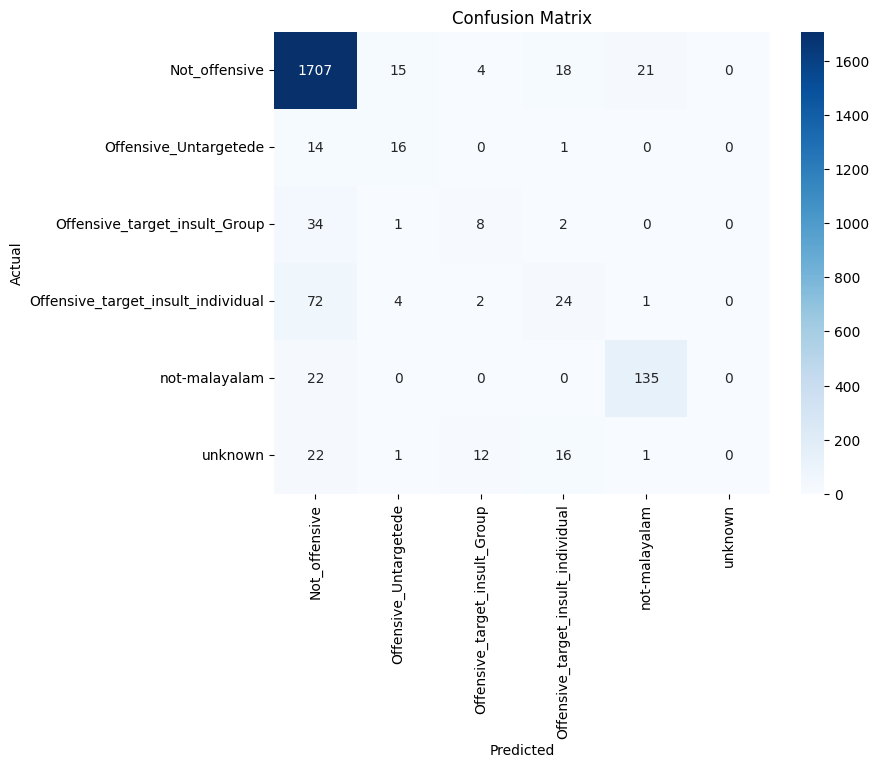

In [9]:

import seaborn as sn
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(test_labels_np, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sn.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


